In [1]:
from datetime import datetime
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from utilities import retrieve_data

ERA_VERSION = 'ERA5'  # One day this will change to ERA6

# ====================
# To get a CDS API key, sign up at https://cds.climate.copernicus.eu/
# It is free and easy! After registering, copy your "Personal Access Token here"
# ====================
KEY = '############################'
KEY = '6cc2b53b-e3c0-42fd-b7ad-db64aeeb5298'
KEY = '8f3ee43a-fa64-4eb9-a403-6567171bb625'

# ====================
# Change these to plot different locations. You can see the currently used ones in the ERA Explorer URL
# ====================
lat = 50.86  # Default latitude
lng = 4.35  # Default longitude

# ====================
# These can be changed to get different data; leave them for now
# ====================
variable = "total_precipitation"
date_range = ["1991-01-01", "2020-12-31"]

# ====================
# Get the data. This will download a NetCDF file
# ====================
data_file = retrieve_data(KEY, variable, date_range, lat, lng)

2024-12-10 15:27:16,490 INFO [2024-07-18T00:00:00] Remember that you need to have an ECMWF account to use CDS-Beta. **Your existing CDS credentials will not work in CDS-Beta!**
2024-12-10 15:27:16,491 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2024-12-10 15:27:16,491 WARNING [2024-06-16T00:00:00] Check our [informative page](https://confluence.ecmwf.int/x/uINmFw) to best prepare yourself to use CDS-Beta.
2024-12-10 15:27:16,491 WARNING [2024-06-16T00:00:00] **BETA version** of the new CDS. Your [feedback](https://jira.ecmwf.int/plugins/servlet/desk/portal/1/create/202) is very useful for us. **Please notice** that access to the system might suffer some disruptions due to evolving updates.


{'variable': ['total_precipitation'], 'date': ['1991-01-01/2020-12-31'], 'location': {'longitude': 4.35, 'latitude': 50.86}, 'data_format': 'netcdf'}
total_precipitation_1991-01-01_2020-12-31_50.86_4.35.nc


2024-12-10 15:27:16,678 INFO Request ID is 624682aa-3b3a-4d5c-a3d1-f634fd6d93ba
2024-12-10 15:27:16,749 INFO status has been updated to accepted
2024-12-10 15:27:17,796 INFO status has been updated to running
2024-12-10 15:27:21,641 INFO status has been updated to successful
                                                                                         

Retrieving data in to:  total_precipitation_1991-01-01_2020-12-31_50.86_4.35.nc


In [2]:
# Make a function to compute the precipitation histogram
def precipHourlyHistogram():
    """
    Generates a histogram of hourly precipitation data.

    This function reads precipitation data from a NetCDF file, converts the time coordinate to a pandas datetime index,
    and creates a DataFrame for easier manipulation. It then resamples the data to hourly accumulations and computes
    a histogram with non-linear bins. The histogram values are converted to percentages, and the bin edges are converted
    to millimeters.

    Returns:
        tuple: A tuple containing:
            - hist_values (numpy.ndarray): The histogram values as percentages.
            - bin_edges (numpy.ndarray): The edges of the bins in millimeters.
    """

    data = xr.open_dataset(data_file)
    data_tp_pt = data.tp

    # Convert the time coordinate to a pandas datetime index
    time_index = pd.to_datetime(data_tp_pt.valid_time.values)

    # Create a DataFrame for easier manipulation
    df = pd.DataFrame(data_tp_pt.values, index=time_index, columns=['tp'])

    # Count the total number of hours in the period
    total = df.resample('h').count().count().values[0]

    # Resample to hourly accumulations
    df_hourly = df.resample('h').sum()

    # Define non-linear bins for the histogram
    bins_nonlinear = np.array([0.0005, 0.001, 0.002, 0.003, 0.005, 0.007, 0.01, 100])

    # Put everything above the max in the last bin
    bins_nonlinear[-1] = 1e6

    # Compute the histogram
    hist_values, bin_edges = np.histogram(df_hourly['tp'], bins=bins_nonlinear)

    # Convert histogram values to percentage
    hist_values = 100 * hist_values / total
    
    # Convert bin edges to mm
    bin_edges = bin_edges * 1000

    return hist_values, bin_edges

hist_values, bin_edges = precipHourlyHistogram()

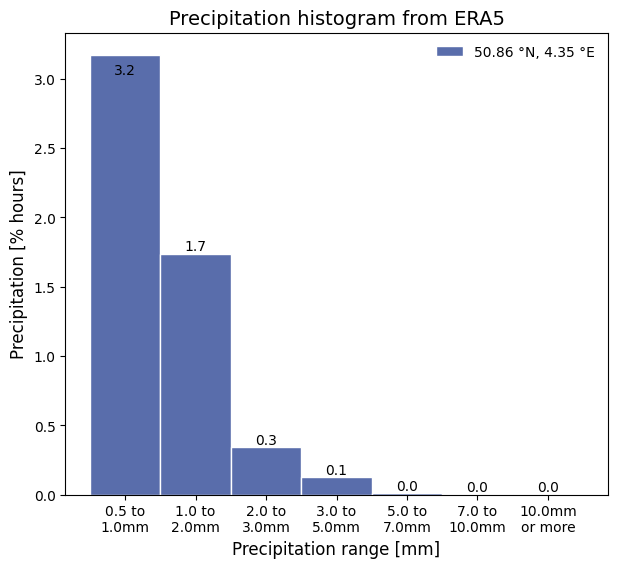

In [3]:
# Make the plot
lw = 2
marker = 'o'
markersize = 4

latSuffix = 'N' if lat > 0 else 'S'
lngSuffix = 'E' if lng > 0 else 'W'

yMax = hist_values.max()

# Create the xtick labels as ranges
xtick_labels = [
    (f'{(bin_edges[i]):.1f} to\n{(bin_edges[i+1]):.1f}mm' if i < len(bin_edges)-2 else
     f'{(bin_edges[-2]):.1f}mm\nor more')
    for i in range(len(bin_edges)-1)
]

# Create a new figure
plt.figure(figsize=(7, 6))

# Plot the data as a bar chart
bars = plt.bar(
    np.arange(len(hist_values)),
    hist_values,
    width=1,
    color='#596DAB',
    label=f'{abs(lat):.2f} °{latSuffix:s}, {abs(lng):.2f} °{lngSuffix:s}',
    edgecolor='white',
    clip_on=False
)

# Add labels to each bar
for index, bar in enumerate(bars):
    value = hist_values[index]
    
    # Compute positions for the text
    x = bar.get_x() + bar.get_width() / 2  # Center of the bar
    
    # Add the labels (daily_min and daily_max) on two lines
    plt.text(
        x,  # X position
        bar.get_height() + bar.get_y() + (-0.02 * yMax if index <= 0 else 0),
        f'{value:.1f}',  # Label text with new line
        ha='center',  # Center horizontally
        va=('bottom' if index > 0 else 'top'),  # Align below the top of the bar
        fontsize=10,  # Font size
        color='black'  # Text color
    )

# Add legend
plt.legend(framealpha=0)

plt.xticks(np.arange(len(hist_values)), xtick_labels)

# plt.ylim(0, hist_values.max())

# Customize x and y axis labels
plt.xlabel('Precipitation range [mm]', fontsize=12)
plt.ylabel("Precipitation [% hours]", fontsize=12)

# Add title with custom font
plt.title('Precipitation histogram from {:s}'.format(ERA_VERSION), fontsize=14)

# Show the plot
# plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()